In [2]:
import tensorflow as tf
import os

In [1]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

NameError: name 'tf' is not defined

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
import cv2
import imghdr

In [6]:
# Directory containing the image data
data_dir = r'C:\Users\Marvin\Documents\WBS\Final_Project\Data\data_2' 

In [7]:
class_names = os.listdir(data_dir)
class_names

['Tomato___bacterial_spot',
 'Tomato___early_blight',
 'Tomato___healthy',
 'Tomato___late_blight',
 'Tomato___leaf_curl',
 'Tomato___leaf_mold',
 'Tomato___mosaic_virus',
 'Tomato___septoria_leaf_spot',
 'Tomato___spider_mites',
 'Tomato___target_spot']

In [8]:
num_classes = len(os.listdir(data_dir))
num_classes

10

In [8]:
# List of image extensions
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
# Remove images with invalid extensions
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

In [10]:
import imghdr

error_images = []

for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip is None: 
                error_images.append(image_path)
                print('Invalid image: {}'.format(image_path))
        except Exception as e: 
            error_images.append(image_path)
            print('Error loading image: {}'.format(image_path))

print("Images causing errors:", error_images)


Images causing errors: []


In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
batch_size = 16
image_size = (256, 256)

In [11]:
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)

Found 18060 files belonging to 10 classes.


In [12]:
data_scaled = data.map(lambda x,y: (x/255, tf.one_hot(y, num_classes)))

In [13]:
train_size = int(0.7 * len(data))
val_size = int(0.2 * len(data))
test_size = len(data) - train_size - val_size

In [14]:
train_data = data_scaled.take(train_size)
val_data = data_scaled.skip(train_size).take(val_size)
test_data = data_scaled.skip(train_size + val_size).take(test_size)

In [15]:
from tensorflow.keras.applications import ResNet50 
from tensorflow.keras import layers, models

In [16]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers[-2:]:
    layer.trainable = True

# Create a new model on top
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(num_classes, activation='softmax'))

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=10,          
    restore_best_weights=True  
)

In [21]:
epochs = 50
hist_tom = model.fit(
    train_data,
    epochs=epochs,
    validation_data=val_data,
    callbacks=[early_stopping]
)

Epoch 1/50
790/790 [==============================] - 231s 280ms/step - loss: 1.2687 - accuracy: 0.6055 - val_loss: 7.6951 - val_accuracy: 0.1578
Epoch 2/50
790/790 [==============================] - 250s 316ms/step - loss: 0.6494 - accuracy: 0.7972 - val_loss: 1.7147 - val_accuracy: 0.5631
Epoch 3/50
790/790 [==============================] - 249s 315ms/step - loss: 0.4577 - accuracy: 0.8574 - val_loss: 2.3790 - val_accuracy: 0.4414
Epoch 4/50
790/790 [==============================] - 257s 325ms/step - loss: 0.3767 - accuracy: 0.8854 - val_loss: 0.4095 - val_accuracy: 0.8769
Epoch 5/50
790/790 [==============================] - 237s 300ms/step - loss: 0.2753 - accuracy: 0.9156 - val_loss: 0.5945 - val_accuracy: 0.8047
Epoch 6/50
790/790 [==============================] - 236s 299ms/step - loss: 0.2515 - accuracy: 0.9221 - val_loss: 0.7622 - val_accuracy: 0.7917
Epoch 7/50
790/790 [==============================] - 237s 300ms/step - loss: 0.2268 - accuracy: 0.9332 - val_loss: 0.3018 -

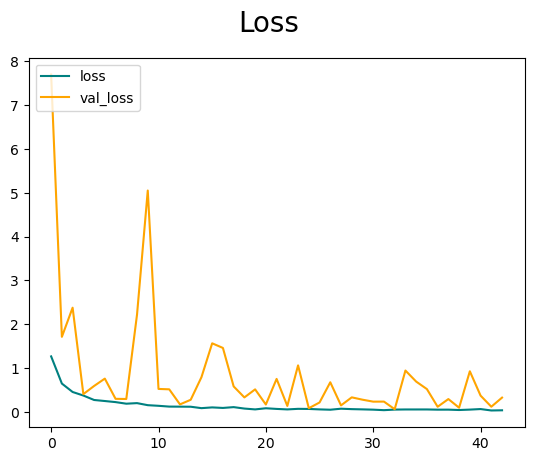

In [22]:
# Plot training and validation loss
fig = plt.figure()
plt.plot(hist_tom.history['loss'], color='teal', label='loss')
plt.plot(hist_tom.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

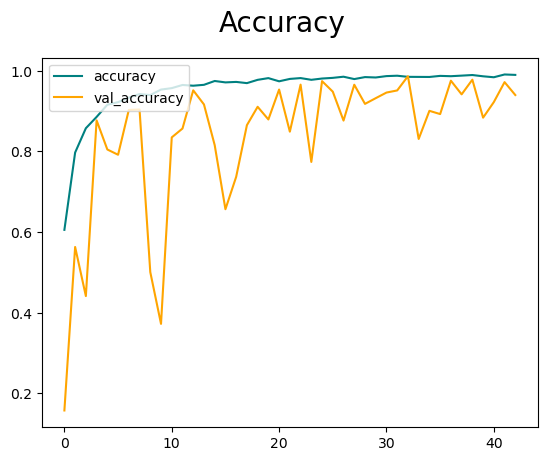

In [23]:
# Plot training and validation accuracy
fig = plt.figure()
plt.plot(hist_tom.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_tom.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [24]:
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall

In [25]:
# Performance-Metriken berechnen
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

114/114 [==============================] - 31s 106ms/step - loss: 0.0668 - accuracy: 0.9868
Test Loss: 0.06682033836841583, Test Accuracy: 0.9868131875991821


In [26]:
# Metrics for multi-class classification
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [27]:
# Update metrics over the test dataset
for batch in test_data.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 44ms/step


In [28]:
# Calculate F1-score
precision = pre.result().numpy()
recall = re.result().numpy()
f1_score = 2 * (precision * recall) / (precision + recall)

In [29]:
# Output performance metrics
print(f'Accuracy: {acc.result().numpy()}, Precision: {precision}, Recall: {recall}, F1-Score: {f1_score}')

Accuracy: 0.9868131875991821, Precision: 0.9883977770805359, Recall: 0.9829670190811157, F1-Score: 0.985674976473976


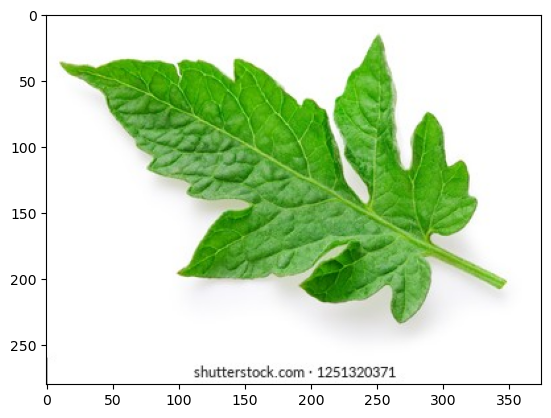

In [59]:
# Load a test image
img = cv2.imread(r'C:\Users\Marvin\Documents\WBS\Final_Project\Data\disese_plant_self_collected\tomato_healthy_4.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

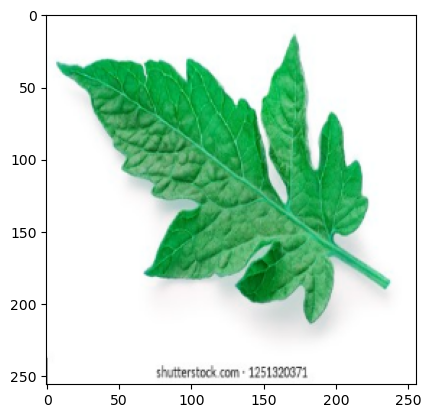

In [60]:
# Resize the image
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [61]:
# Predict the class of the resized image
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 50ms/step


In [63]:
predicted_class = np.argmax(yhat) # Index of the class with the maximum prediction value
predicted_class_name = class_names[predicted_class-1]
print(f'Predicted class: {predicted_class_name}')

Predicted class: Tomato___healthy


In [43]:
predicted_class

1

In [46]:
class_names

['Tomato___bacterial_spot',
 'Tomato___early_blight',
 'Tomato___healthy',
 'Tomato___late_blight',
 'Tomato___leaf_curl',
 'Tomato___leaf_mold',
 'Tomato___mosaic_virus',
 'Tomato___septoria_leaf_spot',
 'Tomato___spider_mites',
 'Tomato___target_spot']

In [64]:
from tensorflow.keras.models import load_model

In [65]:
model.save(os.path.join(r'C:\Users\Marvin\Documents\WBS\Final_Project\Dr.-Greenthumb-Decoding-Nature-s-Needs\Models','multi_diseases_classifier_tomato_98.h5'))

In [ ]:
del model
del hist_tom